In [12]:
#LETS WORK WITH CIFAR 10 DATA 

#ABOUT CIFAR 10 

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

#How to get Images 

 we have  a package called torchvision, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., torchvision.datasets and torch.utils.data.DataLoader.

 

In [13]:
#STEP 1 : LOAD CIFAR 10 DATA
import os
os.path.abspath(os.getcwd())

'/content'

In [14]:
#SECTION1 REQUIRED LIBRARY 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

from drive.MyDrive.S8.utils import Dataloader
from drive.MyDrive.S8.utils import show_images
from drive.MyDrive.S8.utils import classcount
from drive.MyDrive.S8.models import BasicModel
from drive.MyDrive.S8.models import RESNET
from drive.MyDrive.S8.utils import plot_misclassified_image
from drive.MyDrive.S8.utils import perClassResult
from drive.MyDrive.S8.utils import train
from drive.MyDrive.S8.utils import test

In [15]:
#DOWNLOAD THE IMAGES 

class Args:

    # Data Loading
    # ============

    # train_batch_size = 64
    # val_batch_size = 64
    num_workers = 4
    batch_size = 128


    # Regularization
    # ==============
    #dropout = 0.1
    dropout = 0

    # Training
    # ========
    random_seed = 1
    epochs = 15
    learning_rate = 0.01
    momentum = 0.9


In [16]:
import torchvision
import torchvision.transforms as transforms
import torch
trainloader,testloader=Dataloader.train_test_loader(Args.batch_size,Args.num_workers)
classes = Dataloader.get_classes()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


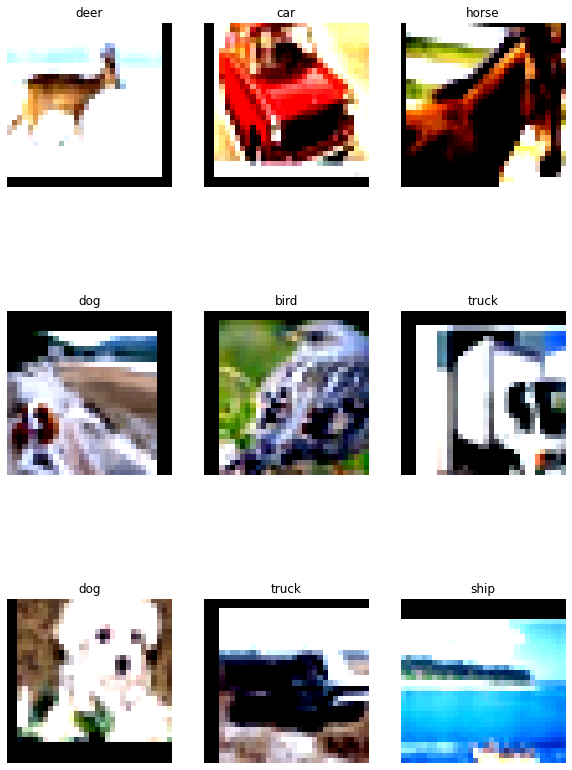

In [17]:
#plot  n raw images 
#make sure n is a squared number 
show_images.plot_n_image(9,trainloader,classes,format='raw')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


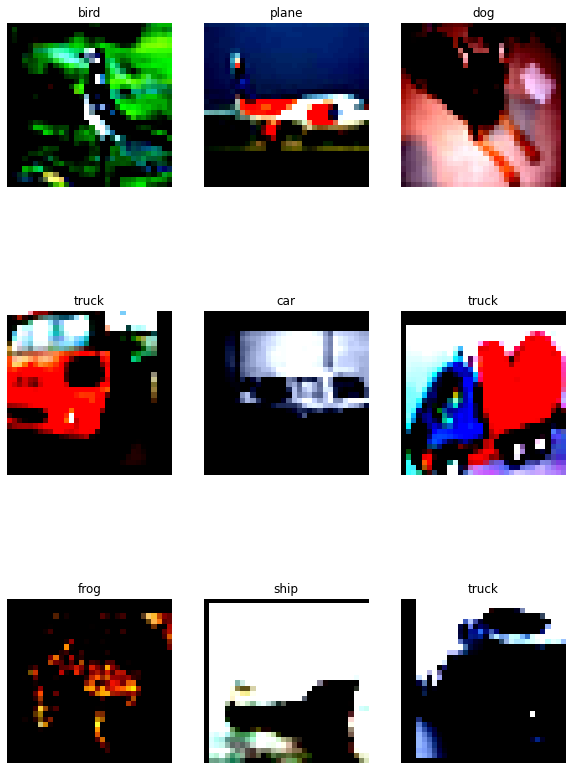

In [18]:
#plot  n normalized images 
#make sure n is a squared number 
show_images.plot_n_image(9,trainloader,classes,format='normalized')

In [19]:
class_count = classcount.get_train_class_count(classes)
print(class_count)

Files already downloaded and verified
{'frog': 5000, 'truck': 5000, 'deer': 5000, 'car': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'plane': 5000}


In [20]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

#working 
#model = BasicModel.Net().to(device)


model = RESNET.ResNet18().to(device) 
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [21]:

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
#criterion = nn.CrossEntropyLoss()
lossfunc = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=12, gamma=0.1)

In [22]:
#Test
EPOCHS = 50

trainer = train.Trainer()
tester  = test.Tester()
lambda_l1=0
for epoch in range(EPOCHS):
  print("EPOCH:", epoch+1, "last LR=",scheduler.get_last_lr(), "CURRENT LR = ", scheduler.get_lr())
  trainer.train(model, device, trainloader, optimizer, lossfunc, epoch, lambda_l1)
  scheduler.step()
  tester.test(model, device, testloader)



test_losses,test_acc=tester.getValuesTest()
train_losses,train_acc=trainer.getValuesTrain()


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 last LR= [0.01] CURRENT LR =  [0.01]


Train set: Loss=0.8398175239562988 Batch_id=390 Accuracy=47.17: 100%|██████████| 391/391 [01:01<00:00,  6.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.5307, Test Accuracy: 5800/10000 (58.00%)

EPOCH: 2 last LR= [0.01] CURRENT LR =  [0.01]


Train set: Loss=0.7202039361000061 Batch_id=390 Accuracy=66.39: 100%|██████████| 391/391 [01:05<00:00,  6.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.5325, Test Accuracy: 6777/10000 (67.77%)

EPOCH: 3 last LR= [0.01] CURRENT LR =  [0.01]


Train set: Loss=0.6377583742141724 Batch_id=390 Accuracy=75.12: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.9423, Test Accuracy: 7541/10000 (75.41%)

EPOCH: 4 last LR= [0.01] CURRENT LR =  [0.01]


Train set: Loss=0.5703450441360474 Batch_id=390 Accuracy=79.38: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.6798, Test Accuracy: 7703/10000 (77.03%)

EPOCH: 5 last LR= [0.01] CURRENT LR =  [0.01]


Train set: Loss=0.5308888554573059 Batch_id=390 Accuracy=81.87: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3745, Test Accuracy: 8262/10000 (82.62%)

EPOCH: 6 last LR= [0.01] CURRENT LR =  [0.01]


Train set: Loss=0.3829494118690491 Batch_id=390 Accuracy=84.35: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.6169, Test Accuracy: 8091/10000 (80.91%)

EPOCH: 7 last LR= [0.01] CURRENT LR =  [0.01]


Train set: Loss=0.675314724445343 Batch_id=390 Accuracy=85.39: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.1942, Test Accuracy: 8132/10000 (81.32%)

EPOCH: 8 last LR= [0.01] CURRENT LR =  [0.01]


Train set: Loss=0.3254997730255127 Batch_id=390 Accuracy=86.49: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.7847, Test Accuracy: 8457/10000 (84.57%)

EPOCH: 9 last LR= [0.01] CURRENT LR =  [0.01]


Train set: Loss=0.4879900813102722 Batch_id=390 Accuracy=87.65: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.3864, Test Accuracy: 8537/10000 (85.37%)

EPOCH: 10 last LR= [0.01] CURRENT LR =  [0.01]


Train set: Loss=0.4569689631462097 Batch_id=390 Accuracy=88.57: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.9777, Test Accuracy: 8198/10000 (81.98%)

EPOCH: 11 last LR= [0.01] CURRENT LR =  [0.01]


Train set: Loss=0.39754316210746765 Batch_id=390 Accuracy=89.43: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -10.1413, Test Accuracy: 8635/10000 (86.35%)

EPOCH: 12 last LR= [0.01] CURRENT LR =  [0.01]


Train set: Loss=0.38970285654067993 Batch_id=390 Accuracy=90.08: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -10.6345, Test Accuracy: 8657/10000 (86.57%)

EPOCH: 13 last LR= [0.001] CURRENT LR =  [0.0001]


Train set: Loss=0.20401914417743683 Batch_id=390 Accuracy=93.56: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -11.3996, Test Accuracy: 9053/10000 (90.53%)

EPOCH: 14 last LR= [0.001] CURRENT LR =  [0.001]


Train set: Loss=0.23014767467975616 Batch_id=390 Accuracy=94.49: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -11.4844, Test Accuracy: 9087/10000 (90.87%)

EPOCH: 15 last LR= [0.001] CURRENT LR =  [0.001]


Train set: Loss=0.20928724110126495 Batch_id=390 Accuracy=94.79: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -11.6337, Test Accuracy: 9087/10000 (90.87%)

EPOCH: 16 last LR= [0.001] CURRENT LR =  [0.001]


Train set: Loss=0.08108363300561905 Batch_id=390 Accuracy=95.00: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -11.7635, Test Accuracy: 9095/10000 (90.95%)

EPOCH: 17 last LR= [0.001] CURRENT LR =  [0.001]


Train set: Loss=0.11074136197566986 Batch_id=390 Accuracy=95.31: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.0137, Test Accuracy: 9099/10000 (90.99%)

EPOCH: 18 last LR= [0.001] CURRENT LR =  [0.001]


Train set: Loss=0.21471109986305237 Batch_id=390 Accuracy=95.62: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.0434, Test Accuracy: 9089/10000 (90.89%)

EPOCH: 19 last LR= [0.001] CURRENT LR =  [0.001]


Train set: Loss=0.1591024100780487 Batch_id=390 Accuracy=95.75: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.2961, Test Accuracy: 9112/10000 (91.12%)

EPOCH: 20 last LR= [0.001] CURRENT LR =  [0.001]


Train set: Loss=0.15722031891345978 Batch_id=390 Accuracy=95.84: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.3106, Test Accuracy: 9121/10000 (91.21%)

EPOCH: 21 last LR= [0.001] CURRENT LR =  [0.001]


Train set: Loss=0.3200940489768982 Batch_id=390 Accuracy=96.08: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.4134, Test Accuracy: 9126/10000 (91.26%)

EPOCH: 22 last LR= [0.001] CURRENT LR =  [0.001]


Train set: Loss=0.12606097757816315 Batch_id=390 Accuracy=96.22: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.4907, Test Accuracy: 9129/10000 (91.29%)

EPOCH: 23 last LR= [0.001] CURRENT LR =  [0.001]


Train set: Loss=0.14223113656044006 Batch_id=390 Accuracy=96.39: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.6672, Test Accuracy: 9112/10000 (91.12%)

EPOCH: 24 last LR= [0.001] CURRENT LR =  [0.001]


Train set: Loss=0.08336344361305237 Batch_id=390 Accuracy=96.62: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.7375, Test Accuracy: 9135/10000 (91.35%)

EPOCH: 25 last LR= [0.0001] CURRENT LR =  [1e-05]


Train set: Loss=0.0611337311565876 Batch_id=390 Accuracy=97.05: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.8389, Test Accuracy: 9140/10000 (91.40%)

EPOCH: 26 last LR= [0.0001] CURRENT LR =  [0.0001]


Train set: Loss=0.06304202973842621 Batch_id=390 Accuracy=96.97: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.8036, Test Accuracy: 9143/10000 (91.43%)

EPOCH: 27 last LR= [0.0001] CURRENT LR =  [0.0001]


Train set: Loss=0.1285649538040161 Batch_id=390 Accuracy=97.07: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.9234, Test Accuracy: 9154/10000 (91.54%)

EPOCH: 28 last LR= [0.0001] CURRENT LR =  [0.0001]


Train set: Loss=0.14067716896533966 Batch_id=390 Accuracy=97.16: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.9190, Test Accuracy: 9159/10000 (91.59%)

EPOCH: 29 last LR= [0.0001] CURRENT LR =  [0.0001]


Train set: Loss=0.057571686804294586 Batch_id=390 Accuracy=97.10: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.9090, Test Accuracy: 9156/10000 (91.56%)

EPOCH: 30 last LR= [0.0001] CURRENT LR =  [0.0001]


Train set: Loss=0.08319815993309021 Batch_id=390 Accuracy=97.24: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.8927, Test Accuracy: 9167/10000 (91.67%)

EPOCH: 31 last LR= [0.0001] CURRENT LR =  [0.0001]


Train set: Loss=0.09583072364330292 Batch_id=390 Accuracy=97.22: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.9064, Test Accuracy: 9154/10000 (91.54%)

EPOCH: 32 last LR= [0.0001] CURRENT LR =  [0.0001]


Train set: Loss=0.0513647198677063 Batch_id=390 Accuracy=97.18: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.9899, Test Accuracy: 9151/10000 (91.51%)

EPOCH: 33 last LR= [0.0001] CURRENT LR =  [0.0001]


Train set: Loss=0.06574416905641556 Batch_id=390 Accuracy=97.34: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.8750, Test Accuracy: 9162/10000 (91.62%)

EPOCH: 34 last LR= [0.0001] CURRENT LR =  [0.0001]


Train set: Loss=0.12762121856212616 Batch_id=390 Accuracy=97.16: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.8757, Test Accuracy: 9149/10000 (91.49%)

EPOCH: 35 last LR= [0.0001] CURRENT LR =  [0.0001]


Train set: Loss=0.12435493618249893 Batch_id=390 Accuracy=97.31: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.9086, Test Accuracy: 9165/10000 (91.65%)

EPOCH: 36 last LR= [0.0001] CURRENT LR =  [0.0001]


Train set: Loss=0.09503819048404694 Batch_id=390 Accuracy=97.32: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.9677, Test Accuracy: 9160/10000 (91.60%)

EPOCH: 37 last LR= [1e-05] CURRENT LR =  [1.0000000000000002e-06]


Train set: Loss=0.16942961513996124 Batch_id=390 Accuracy=97.31: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.9505, Test Accuracy: 9162/10000 (91.62%)

EPOCH: 38 last LR= [1e-05] CURRENT LR =  [1e-05]


Train set: Loss=0.06313182413578033 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.9543, Test Accuracy: 9169/10000 (91.69%)

EPOCH: 39 last LR= [1e-05] CURRENT LR =  [1e-05]


Train set: Loss=0.04755055159330368 Batch_id=390 Accuracy=97.34: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.9592, Test Accuracy: 9149/10000 (91.49%)

EPOCH: 40 last LR= [1e-05] CURRENT LR =  [1e-05]


Train set: Loss=0.06777872145175934 Batch_id=390 Accuracy=97.30: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.9992, Test Accuracy: 9164/10000 (91.64%)

EPOCH: 41 last LR= [1e-05] CURRENT LR =  [1e-05]


Train set: Loss=0.14017993211746216 Batch_id=390 Accuracy=97.33: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -13.0068, Test Accuracy: 9165/10000 (91.65%)

EPOCH: 42 last LR= [1e-05] CURRENT LR =  [1e-05]


Train set: Loss=0.0927712470293045 Batch_id=390 Accuracy=97.43: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.9379, Test Accuracy: 9154/10000 (91.54%)

EPOCH: 43 last LR= [1e-05] CURRENT LR =  [1e-05]


Train set: Loss=0.046752236783504486 Batch_id=390 Accuracy=97.38: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.9821, Test Accuracy: 9165/10000 (91.65%)

EPOCH: 44 last LR= [1e-05] CURRENT LR =  [1e-05]


Train set: Loss=0.08976288139820099 Batch_id=390 Accuracy=97.37: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -13.0088, Test Accuracy: 9165/10000 (91.65%)

EPOCH: 45 last LR= [1e-05] CURRENT LR =  [1e-05]


Train set: Loss=0.035643842071294785 Batch_id=390 Accuracy=97.42: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -13.0247, Test Accuracy: 9157/10000 (91.57%)

EPOCH: 46 last LR= [1e-05] CURRENT LR =  [1e-05]


Train set: Loss=0.04600069299340248 Batch_id=390 Accuracy=97.39: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -13.0066, Test Accuracy: 9168/10000 (91.68%)

EPOCH: 47 last LR= [1e-05] CURRENT LR =  [1e-05]


Train set: Loss=0.04239175468683243 Batch_id=390 Accuracy=97.39: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.8714, Test Accuracy: 9167/10000 (91.67%)

EPOCH: 48 last LR= [1e-05] CURRENT LR =  [1e-05]


Train set: Loss=0.11366275697946548 Batch_id=390 Accuracy=97.32: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.9644, Test Accuracy: 9166/10000 (91.66%)

EPOCH: 49 last LR= [1.0000000000000002e-06] CURRENT LR =  [1.0000000000000002e-07]


Train set: Loss=0.09102576971054077 Batch_id=390 Accuracy=97.37: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -13.0495, Test Accuracy: 9163/10000 (91.63%)

EPOCH: 50 last LR= [1.0000000000000002e-06] CURRENT LR =  [1.0000000000000002e-06]


Train set: Loss=0.06777317821979523 Batch_id=390 Accuracy=97.36: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Test set: Average loss: -12.9955, Test Accuracy: 9162/10000 (91.62%)



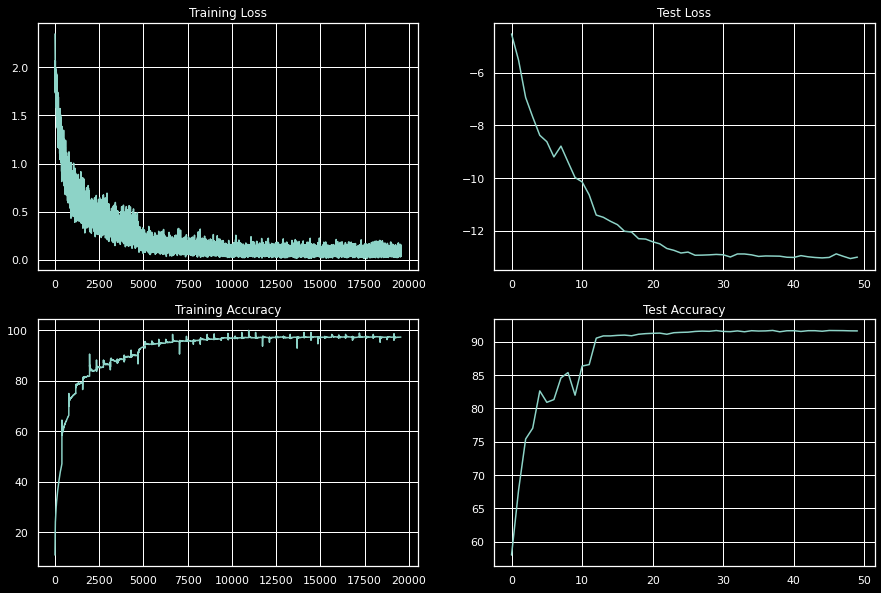

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [24]:
#Save the model
torch.save(model,'./data/cifar')
#load the model
model = torch.load('./data/cifar')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [25]:
#GET PERCENTAGE ACCURACY FOR EACH CLASS      
perClassResult.get_percent_acc_each_class(model,device,classes,testloader)

Accuracy of plane : 96 %
Accuracy of   car : 97 %
Accuracy of  bird : 82 %
Accuracy of   cat : 81 %
Accuracy of  deer : 93 %
Accuracy of   dog : 84 %
Accuracy of  frog : 93 %
Accuracy of horse : 90 %
Accuracy of  ship : 94 %
Accuracy of truck : 96 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

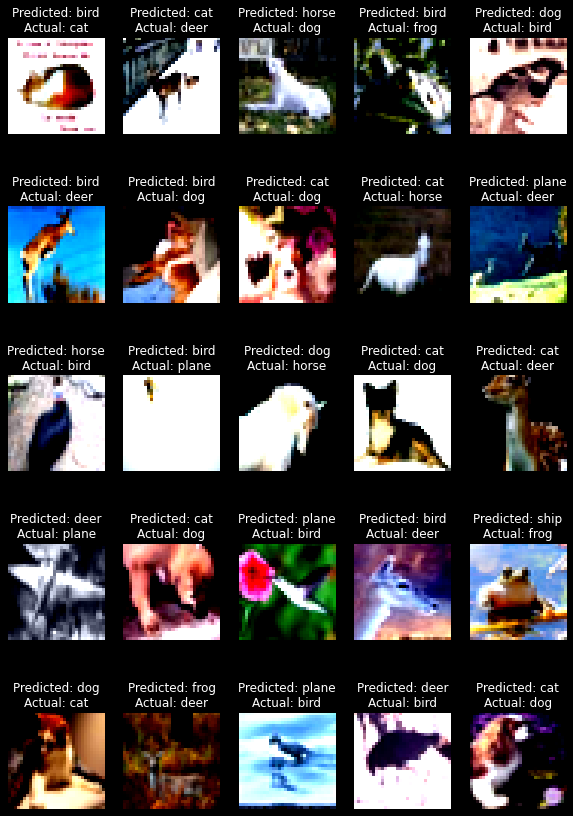

In [26]:
#Plot misclassified Image
plot_misclassified_image.plot_misclassified(25, testloader, device,model,classes)

In [27]:
len(train_acc),len(train_losses)

(19550, 19550)